In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
home = '/content/drive/MyDrive/DAIHOCBACHKHOA/HK212/Đồ án AI siêu cấp vip pro max/AI/Do an/'
%cd {home}

/content/drive/.shortcut-targets-by-id/1jO5E4Qd61jT0Ra-JkWljnagRp9ni15uU/Do an


In [3]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, resnet_v2, inception_v3, inception_resnet_v2

# check version number
import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Check valid image data

In [4]:
import tqdm

In [5]:
# import os
# import cv2
# def check_images( s_dir, ext_list):
#     bad_images=[]
#     bad_ext=[]
#     s_list= os.listdir(s_dir)
#     for klass in s_list:
#         klass_path=os.path.join (s_dir, klass)
#         print ('processing class directory ', klass)
#         if os.path.isdir(klass_path):
#             file_list=os.listdir(klass_path)
#             for f in tqdm.tqdm(file_list):               
#                 f_path=os.path.join (klass_path,f)
#                 # index=f.rfind('.')
#                 # ext=f[index+1:].lower()
#                 # if ext not in ext_list:
#                 #     print('file ', f_path, ' has an invalid extension ', ext)
#                 #     bad_ext.append(f_path)
#                 if os.path.isfile(f_path):
#                     try:
#                       img = tf.io.read_file(f_path)
#                       img = tf.image.decode_image(img, channels=3, expand_animations=False)
#                     except:
#                         print('file ', f_path, ' is not a valid image file')
#                         bad_images.append(f_path)
#                 else:
#                     print('*** fatal error, you have a sub directory ', f, ' in class directory ', klass)
#         else:
#             print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
#     return bad_images, bad_ext

In [6]:
# source_dir ='/content/drive/MyDrive/Do an/test'
# source_dir ='data/RMFRD/train'
# good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
# bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
# if len(bad_file_list) !=0:
#     print('improper image files are listed below')
#     for i in range (len(bad_file_list)):
#         print (bad_file_list[i])
# else:
#     print(' no improper image files were found')

# Delete improper image

In [7]:
# for i in bad_file_list:
#   os.remove(i)
#   print(i, 'was removed')

# Setting up envirionment

In [8]:
class args:
    backbone = 'ResNet50V2'    # use one of: vgg16 ResNet50V2 inception_v3 inception_resnet_v2
    img_size = (224,224)
    batch_size = 128
    lr = 2e-4
    epochs = 10
    use_augmentation = False
    seed = 10
    steps_per_epoch = None
    # train_data_path = '/content/drive/MyDrive/Do an/train'
    # val_data_path = '/content/drive/MyDrive/Do an/test'
    # model_path = '/content/drive/MyDrive/Do an/Model'
    train_data_path = 'data/RMFRD/train'
    val_data_path = 'data/RMFRD/test'
    model_path = 'Model'



def preprocess_image(image):
  if args.backbone == 'vgg16':
    image = vgg16.preprocess_input(image)
  elif args.backbone == 'ResNet50V2':
    image = resnet_v2.preprocess_input(image)
  elif args.backbone == 'inception_v3':
    image = inception_v3.preprocess_input(image)
  elif args.backbone == 'inception_resnet_v2':
    image = inception_resnet_v2.preprocess_input(image)
  return  image


def preprocess(images, labels):
  images = preprocess_image(images)
  return images, labels


# aug = ImageDataGenerator(
# 	rotation_range=20,
# 	zoom_range=0.15,
# 	width_shift_range=0.2,
# 	height_shift_range=0.2,
# 	shear_range=0.15,
# 	horizontal_flip=True,
# 	fill_mode="nearest",
#   preprocessing_function=preprocess_image)

# Preparing data

In [9]:
### loop_inf: if False, the generator will stop based all the number of data in pivot class
def train_data_generator(class_names = ['without_mask', 'with_mask'], loop_inf = False, pivot_class=1):
    n_class = len(class_names)
    file_lists = [   np.random.shuffle(os.listdir(os.path.join(args.train_data_path, i)) ) for i in class_names]
    idx_list = [0]*n_class
    idx_class = 0
    while True:
        img_path = os.path.join(args.train_data_path, class_names[idx_class], file_lists[idx_class][idx_list[idx_class]])
        print(img_path)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize([img], args.img_size)
        img, label = preprocess(img, idx_class)

        idx_list[idx_class] = (idx_list[idx_class]+1) % len(file_lists[idx_class])
        if idx_class==pivot_class and idx_list[idx_class]==0 and not loop_inf:
            break
        idx_class = (idx_class+1)%n_class

        yield img[0], label

### loop_inf: if False, the generator will stop based all the number of data in pivot class
def test_data_generator(class_names = ['without_mask', 'with_mask'], loop_inf = False, pivot_class=1):
    n_class = len(class_names)
    # tmp_ls = [os.path.join(args.val_data_path, i) for i in class_names]
    # print(tmp_ls)
    file_lists = [  os.listdir(os.path.join(args.val_data_path, i))  for i in class_names]
    idx_list = [0]*n_class
    idx_class = 0
    while True:
        img_path = os.path.join(args.val_data_path, class_names[idx_class], file_lists[idx_class][idx_list[idx_class]])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize([img], args.img_size)
        img, label = preprocess(img, idx_class)

        idx_list[idx_class] = (idx_list[idx_class]+1) % len(file_lists[idx_class])
        if idx_class==pivot_class and idx_list[idx_class]==0 and not loop_inf:
            break
        idx_class = (idx_class+1)%n_class

        yield img[0], label

In [10]:
    BATCH_SIZE = args.batch_size
BUFFER_SIZE = args.batch_size*4

train_dataset = tf.data.Dataset.from_generator(
    train_data_generator,
    output_signature = (
        tf.TensorSpec(
            shape=(args.img_size[0], args.img_size[1], 3), 
            dtype=tf.float32,
        ) , tf.TensorSpec(
            shape=(), 
            dtype=tf.float32,
        )  
    )
)

# for x1,x2 in train_dataset.take(3):
    # print(x1)
    # print(x2)

train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(args.batch_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
# for x1,x2 in train_dataset.take(1):
#     print(x1)
#     print(x2)

In [11]:
test_dataset = tf.data.Dataset.from_generator(
    test_data_generator,
    output_signature = (
        tf.TensorSpec(
            shape=(args.img_size[0], args.img_size[1], 3), 
            dtype=tf.float32,
        ) , tf.TensorSpec(
            shape=(), 
            dtype=tf.float32,
        )  
    )
)

# for x1,x2 in train_dataset.take(3):
    # print(x1)
    # print(x2)

test_dataset = (
    test_dataset
    .shuffle(BUFFER_SIZE)
    .batch(args.batch_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
# for x1,x2 in train_dataset.take(1):
#     print(x1)
#     print(x2)

In [12]:
# if args.use_augmentation:
#   train_ds = aug.flow_from_directory(directory=args.train_data_path,
#                                      target_size=args.img_size,
#                                      color_mode='rgb',
#                                      classes=['without_mask', 'with_mask'],
#                                      class_mode='binary',
#                                      batch_size=args.batch_size,
#                                      shuffle=True,
#                                      seed=args.seed)
# else:
#   train_ds = tf.keras.utils.image_dataset_from_directory(directory=args.train_data_path, 
#                                                  labels="inferred", 
#                                                  label_mode='binary',
#                                                  class_names=['without_mask', 'with_mask'],
#                                                  color_mode='rgb',
#                                                  batch_size=args.batch_size, 
#                                                  image_size=args.img_size,
#                                                  shuffle=True,
#                                                  seed=args.seed).map(preprocess)

# val_ds = tf.keras.utils.image_dataset_from_directory(directory=args.val_data_path,
#                                                  labels="inferred", 
#                                                  label_mode='binary',
#                                                  class_names=['without_mask', 'with_mask'],
#                                                  color_mode='rgb',
#                                                  batch_size=args.batch_size, 
#                                                  image_size=args.img_size,
#                                                  shuffle=True,
#                                                  seed=args.seed).map(preprocess)

# print(train_ds)
# print(val_ds)

In [ ]:
gen = train_data_generator()
while True:
    next(gen)

# Build model

In [13]:
%%capture

# Get backbone
if args.backbone == 'vgg16':
  backbone = vgg16.VGG16(weights="imagenet", input_shape=args.img_size + (3,), include_top=False)
elif args.backbone == 'ResNet50V2':
  backbone = resnet_v2.ResNet50V2(weights="imagenet", input_shape=args.img_size + (3,), include_top=False)
elif args.backbone == 'inception_v3':
  backbone = inception_v3.InceptionV3(weights="imagenet", input_shape=args.img_size + (3,), include_top=False)
elif args.backbone == 'inception_resnet_v2':
  backbone = inception_resnet_v2.InceptionResNetV2.InceptionV3(weights="imagenet", input_shape=args.img_size + (3,), include_top=False)

flatten = layers.Flatten()(backbone.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(1, activation='sigmoid')(dense2)

# Freeze the backbone weight
for layer in backbone.layers:
  layer.trainable = False

model = Model(backbone.input, output)

model.summary()

# Training

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer=Adam(args.lr),
              loss = BinaryCrossentropy(), 
              metrics = ['accuracy', precision_m, recall_m, f1_m])

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    steps_per_epoch=args.steps_per_epoch,
                    epochs=args.epochs,
                    verbose=1)

Epoch 1/10


UnknownError: ignored

# Save model

In [ ]:
import os
model_name = f'face_mask_detection_{args.backbone}.h5'
model.save(os.path.join(args.model_path,model_name))

# Visualization

Text(0.5, 1.0, 'Training and validation loss')

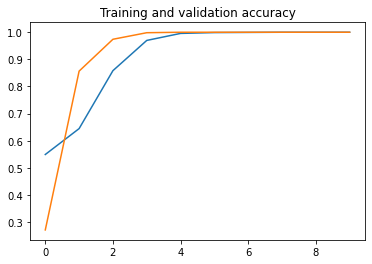

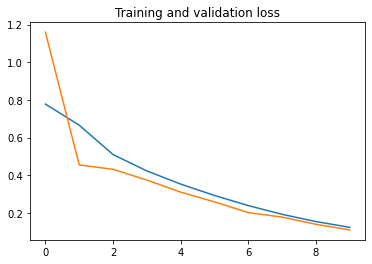

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy' ]
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')